# Método de clustering para la segmentación de clientes de un banco

## Detalles

### Detalles sobre el dataset utilizado
El conjunto de datos contiene 1000 entradas con 20 atributos categóricos / simbólicos preparados por el Prof. Hofmann. En este conjunto de datos, cada entrada representa a una persona que recibe un crédito de un banco. Cada persona se clasifica como riesgo crediticio bueno o malo según el conjunto de atributos. 

Enlace al dataset, del Machine Learning Respository: https://archive.ics.uci.edu/ml/datasets/Statlog+%28German+Credit+Data%29
#### Campos:

* Age (numeric)
* Sex (text: male, female)
* Job (numeric: 0 - unskilled and non-resident, 1 - unskilled and resident, 2 - skilled, 3 - highly skilled)
* Housing (text: own, rent, or free)
* Saving accounts (text - little, moderate, quite rich, rich)
* Checking account (numeric, in DM - Deutsch Mark)
* Credit amount (numeric, in DM)
* Duration (numeric, in month)
* Purpose (text: car, furniture/equipment, radio/TV, domestic appliances, repairs, education, business, vacation/others)

### Detalles del método a aplicar para realizar la segmentación (K-means):

K-medias (K-means) es un método de agrupamiento, que tiene como objetivo la partición de un conjunto de n observaciones en k grupos en el que cada observación pertenece al grupo cuyo valor medio es más cercano. 

K-means es un algoritmo de clasificación no supervisada (clusterización) que agrupa objetos en k grupos basándose en sus características. El agrupamiento se realiza minimizando la suma de distancias entre cada objeto y el centroide de su grupo o cluster. Se suele usar la distancia cuadrática.

El algoritmo consta de tres pasos:

Inicialización: una vez escogido el número de grupos, k, se establecen k centroides en el espacio de los datos, por ejemplo, escogiéndolos aleatoriamente.
Asignación objetos a los centroides: cada objeto de los datos es asignado a su centroide más cercano.
Actualización centroides: se actualiza la posición del centroide de cada grupo tomando como nuevo centroide la posición del promedio de los objetos pertenecientes a dicho grupo.
Se repiten los pasos 2 y 3 hasta que los centroides no se mueven, o se mueven por debajo de una distancia umbral en cada paso.

El algoritmo k-means resuelve un problema de optimización, siendo la función a optimizar (minimizar) la suma de las distancias cuadráticas de cada objeto al centroide de su cluster.

Más información del funcionamiento del algoritmo en: http://www.unioviedo.es/compnum/laboratorios_py/kmeans/kmeans.html

## Carga de la información

In [1]:
# Librerías para el manejo numérico / algebraico:
import pandas as pd
import numpy as np

# Librerias de visualización:
import seaborn as sns
import matplotlib.pyplot as plt
%matplotlib inline

# Librerías de machine learning:
from sklearn.preprocessing import StandardScaler
from sklearn.cluster import KMeans, AffinityPropagation

# Otras:
import warnings
warnings.filterwarnings("ignore")

from IPython.core.display import HTML # Para centrar los gráficos:
HTML("""
<style>
.output_png {
    display: table-cell;
    text-align: center;
    vertical-align: middle;
}
</style>
""")

In [2]:
df = pd.read_csv("credit_data.csv")

In [3]:
df.head()

,Unnamed: 0,Age,Sex,Job,Housing,Saving accounts,Checking account,Credit amount,Duration,Purpose
0,0,67,male,2,own,NaN,little,1169,6,radio/TV
1,1,22,female,2,own,little,moderate,5951,48,radio/TV
2,2,49,male,1,own,little,NaN,2096,12,education
3,3,45,male,2,free,little,little,7882,42,furniture/equipment
4,4,53,male,2,free,little,little,4870,24,car


In [4]:
# Quitando la primer columna ya que es una copia del índice:
df.drop(df.columns[0], inplace=True, axis=1)

In [5]:
df.head()

,Age,Sex,Job,Housing,Saving accounts,Checking account,Credit amount,Duration,Purpose
0,67,male,2,own,NaN,little,1169,6,radio/TV
1,22,female,2,own,little,moderate,5951,48,radio/TV
2,49,male,1,own,little,NaN,2096,12,education
3,45,male,2,free,little,little,7882,42,furniture/equipment
4,53,male,2,free,little,little,4870,24,car


In [6]:
# Chequeando valores faltantes:

print("El dataframe tiene {} observaciones (clientes) y {} columnas (atributos).".format(df.shape[0],df.shape[1]))
print("\n")
print("Valores faltantes en cada columna:\n{}".format(df.isnull().sum()))
print("\n")
print("Tipo de dato de cada columna:\n{}".format(df.dtypes))

El dataframe tiene 1000 observaciones (clientes) y 9 columnas (atributos).


Valores faltantes en cada columna:
Age                   0
Sex                   0
Job                   0
Housing               0
Saving accounts     183
Checking account    394
Credit amount         0
Duration              0
Purpose               0
dtype: int64


Tipo de dato de cada columna:
Age                  int64
Sex                 object
Job                  int64
Housing             object
Saving accounts     object
Checking account    object
Credit amount        int64
Duration             int64
Purpose             object
dtype: object


Los valores faltantes encontrados se refieren a clientes que no poseen ese tipo de cuenta ("Saving account" o "Checking account"), por lo que no es necesario eliminar esas filas del dataframe

In [7]:
# Chequeando los valores únicos en cada columna (valores posibles que pueden tomar):

print("Cantidad de valores únicos:\n{}".format(df.nunique()))

Cantidad de valores únicos:
Age                  53
Sex                   2
Job                   4
Housing               3
Saving accounts       4
Checking account      3
Credit amount       921
Duration             33
Purpose               8
dtype: int64


In [8]:
# Analizando únicamente en las columnas que tienen tipo de dato categórico (dato tipo "object"), ya que los otros son valores numéricos:

print("Valores únicos en columnas con datos categóricos:")
print("\n")
for col in df.select_dtypes(include=[object]): #selecciona solo las columnas con datos categóricos
    print(col,":", df[col].unique())         #muestra los valores únicos posibles

Valores únicos en columnas con datos categóricos:


Sex : ['male' 'female']
Housing : ['own' 'free' 'rent']
Saving accounts : [nan 'little' 'quite rich' 'rich' 'moderate']
Checking account : ['little' 'moderate' nan 'rich']
Purpose : ['radio/TV' 'education' 'furniture/equipment' 'car' 'business'
 'domestic appliances' 'repairs' 'vacation/others']


## Análisis exploratorio de la información 

En primer lugar se va analizar por medio de gráficos de dispersión las relaciones entre distintas variables, para esto en primer lugar se crea una función para luego llamarla según lo que se quiera comparar:

In [9]:
# Creando la función:

def dispersion(df, h=None, pal=None):
    """
    Función que recibe un dataframe y los datos a comparar, devuelve unos gráficos de dispersión comparando eso.
    """
    fig, (ax1, ax2, ax3) = plt.subplots(3,1, figsize=(8,8)) # para crear 3 gráficos, uno arriba de otro
    sns.scatterplot(x="Credit amount",y="Duration", hue=h, palette=pal, data=df, ax=ax1)
    sns.scatterplot(x="Age",y="Credit amount", hue=h, palette=pal, data=df, ax=ax2)
    sns.scatterplot(x="Age",y="Duration", hue=h, palette=pal, data=df, ax=ax3)
    plt.tight_layout()

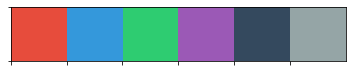

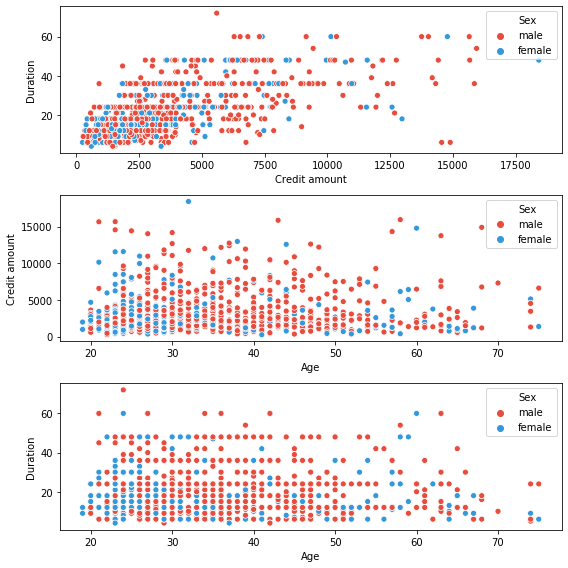

In [10]:
# Creando una paleta de colores personalizada:

colores = ["#e74c3c", "#3498db", "#2ecc71", "#9b59b6", "#34495e","#95a5a6"]
sns.palplot(sns.color_palette(colores))

# Llamando la función para comparar:

dispersion(df, h="Sex", pal=sns.color_palette(colores, 2))

La primera impresión es que las clientes mujeres tienden a ser más jóvenes que los clientes hombres, sin embargo, el primer gráfico muestra que no existe una diferencia clara entre hombres y mujeres en términos de monto y duración del crédito. 

De la inspección visual, parece que hay una cierta correlación positiva entre la duración y la cantidad de crédito (primer gráfico), lo que tiene sentido.

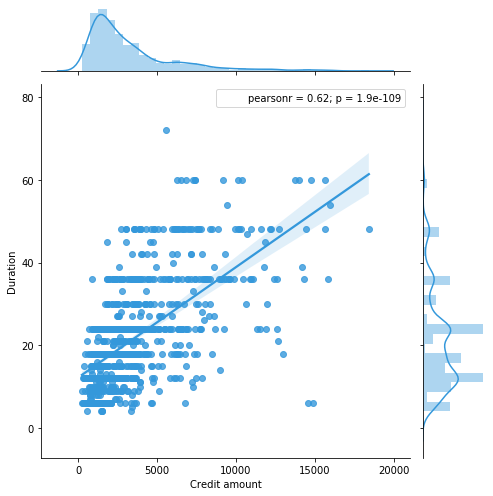

In [11]:
# Revisando la correlación lineal entre el monto del crédito y la duración:

import scipy.stats as stats
r1 = sns.jointplot(x="Credit amount",y="Duration", data=df, kind="reg", height=7, color="#3498db")
r1.annotate(stats.pearsonr)
plt.show()

El gráfico muestra una correlación lineal con el valor de Pearson de 0,62 y un valor p muy pequeño. Eso tiene sentido porque, geneneralmente, las personas obtienen créditos más grandes durante períodos más largos. 

Nota: En estadística, el coeficiente de correlación de Pearson es una medida de dependencia lineal entre dos variables aleatorias cuantitativas. A diferencia de la covarianza, la correlación de Pearson es independiente de la escala de medida de las variables. De manera menos formal, podemos definir el coeficiente de correlación de Pearson como un índice que puede utilizarse para medir el grado de relación de dos variables siempre y cuando ambas sean cuantitativas y continuas.

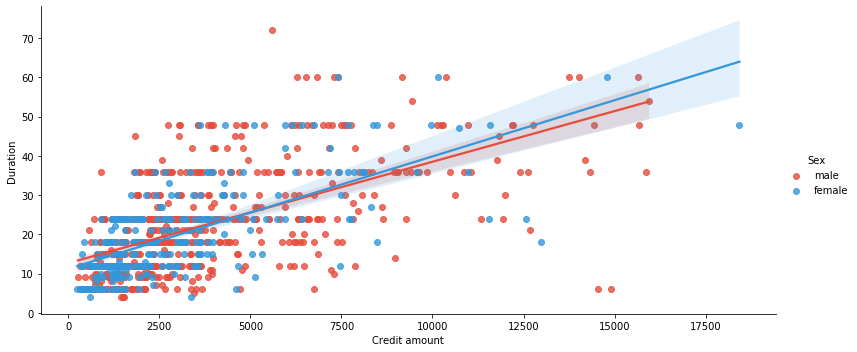

In [12]:
# Graficando regresiones lineales de distintas categorias:

# Cantidad de crédido y duración:

sns.lmplot(x="Credit amount",
           y="Duration", 
           hue="Sex", 
           data=df, 
           palette=sns.color_palette(colores, 2), 
           aspect=2.2)
plt.show()

Puede notarse que no hay mucha diferencia en el género del cliente.

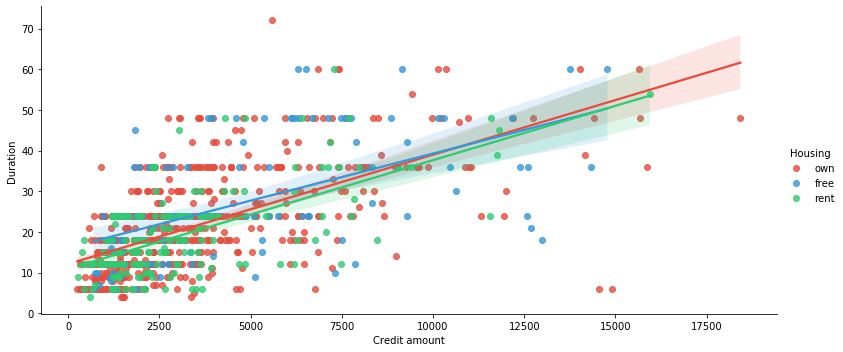

In [13]:
# En función del tipo de alojamiento (propia, gratis, alquiler):

sns.lmplot(x="Credit amount",
           y="Duration", 
           hue="Housing", 
           data=df, 
           palette=sns.color_palette(colores, 3), 
           aspect=2.2)
plt.show()

Tampoco hay diferencia perceptible en las distintas categorías de alojamiento.

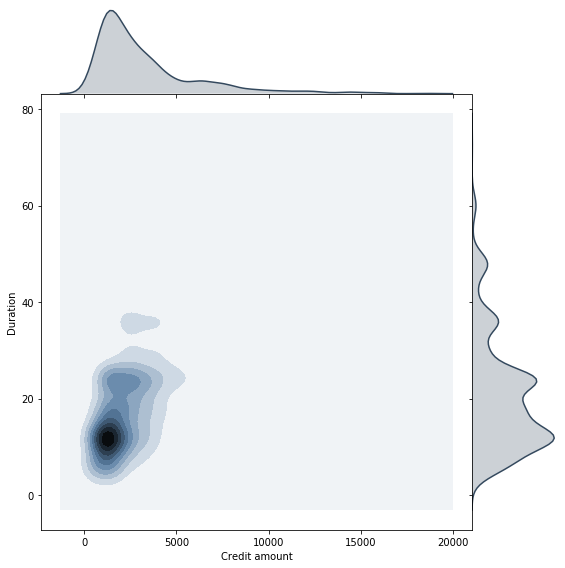

In [14]:
sns.jointplot("Credit amount",
              "Duration", 
              data=df, 
              kind="kde", 
              space=0, 
              color="#34495e",  
              height=8)
plt.show()

In [15]:
# Comparando la cantidad de créditos otorgados, según cada tipo de negocio (distintas categorías en la columna "purpoise")

cant_cred = df.groupby("Purpose")["Age"].count().rename("Count").reset_index()
cant_cred.sort_values(by=["Count"], ascending=False, inplace=True)
cant_cred

,Purpose,Count
1,car,337
5,radio/TV,280
4,furniture/equipment,181
0,business,97
3,education,59
6,repairs,22
2,domestic appliances,12
7,vacation/others,12


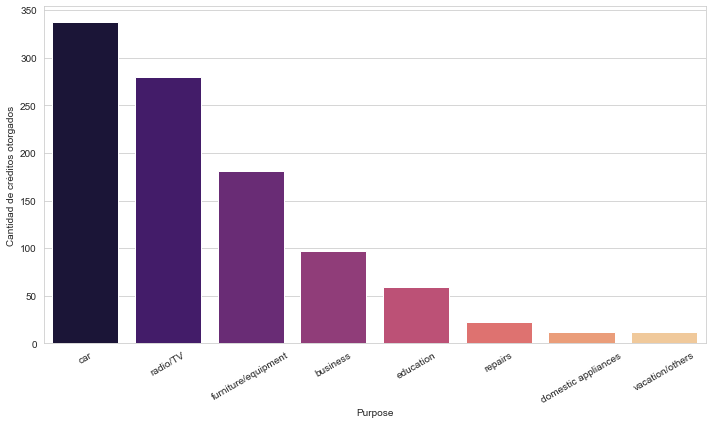

In [16]:
plt.figure(figsize=(10,6))
sns.set_style("whitegrid") # para que muestre la grilla
grafico_bar = sns.barplot(x="Purpose",y="Count",data=cant_cred, palette="magma")
grafico_bar.set_xticklabels(grafico_bar.get_xticklabels(), rotation=30) #Añadiendo etiquetas a 30 grados
plt.ylabel("Cantidad de créditos otorgados")
plt.tight_layout()

Puede verse que la mayoría de créditos otorgados son para vehiculos ("car") y radio/TV, lo que concuerda con lo visto anteriormente de que la mayoría de los creditos ortorgados eran en "pequeñas" cantidades y a corta duración.

In [17]:
# Realizando un análisis sobre las distribuciones de monto de créditos otorgados, en funcion de las distintas categorías y género:
# Creando la función:

def boxes(df,x,y,h, r):
    """
    Función que recibe:
    - Dataframe (df)
    - Categorías (x)
    - Variable sobre la cual analizar la distribución (y)
    - Hue (h), para comparar según lo que se busque
    - Radio (r) de inclinación de las etiquetas, ya que en algunos es necesario para que se puedan leer fácilmente
    """
    fig, ax = plt.subplots(figsize=(10,6))
    box = sns.boxplot(x=x,y=y, hue=h, data=df)
    box.set_xticklabels(box.get_xticklabels(), rotation=r)
    fig.subplots_adjust(bottom=0.2)
    plt.tight_layout()

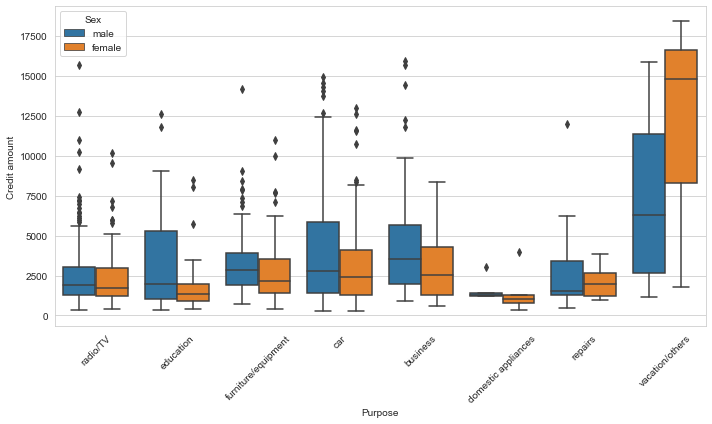

In [18]:
# y = Valor en credito otorgado:

boxes(df, "Purpose","Credit amount","Sex", 45)

El gráfico muestra que las mayores cantidades se toman para vacaciones / otros, las menores para electrodomésticos. 

La mayoría de ellos tienen valores atípicos en la parte superior de las casillas (cantidades más altas). 

En la mayoría de los casos no hay diferencia entre hombres y mujeres salvo en los siguientes casos:

* Educación: Montos mas grande en general para los varones.
* Vacaciones / Otros: Una gran diferencia, pero hay que tener en cuenta que se consedieron muy pocos créditos en ésta categoría.

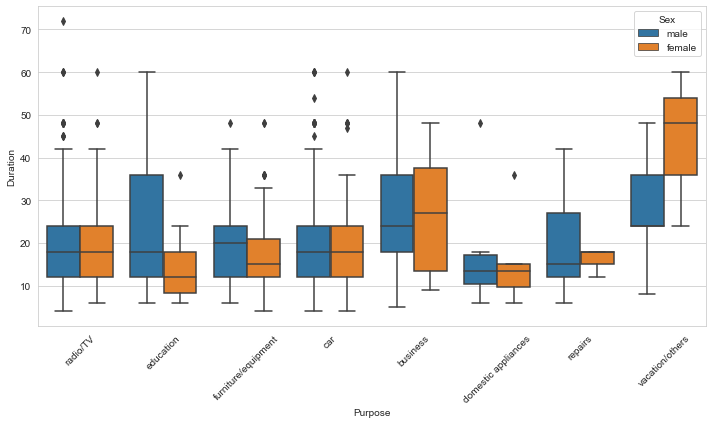

In [19]:
# y = Duración del crédito otorgado

boxes(df, "Purpose","Duration","Sex", 45)

A primera vista los resultados no son muy distintos, ya que anteriormente se había notado la gran correlación entre la duración y los montos de los créditos otorgados.

Los electrodomésticos ("domestic appliances") son la categoría con duraciones de crédito más bajas.

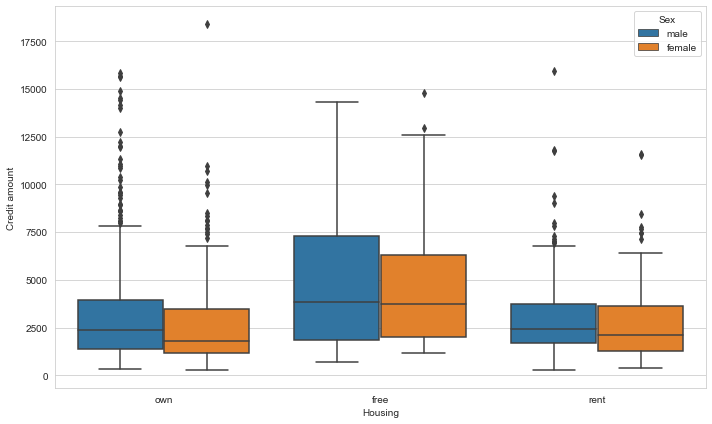

In [20]:
# y = Valor en crédito otorgado
# x = categorías de alojamiento

boxes(df, "Housing","Credit amount","Sex", 0)

En términos de categorías de alojamiento, no hay una gran diferencia a pesar de que las personas que tienen vivienda "gratuita" tienden a recibir montos de crédito ligeramente mayores.

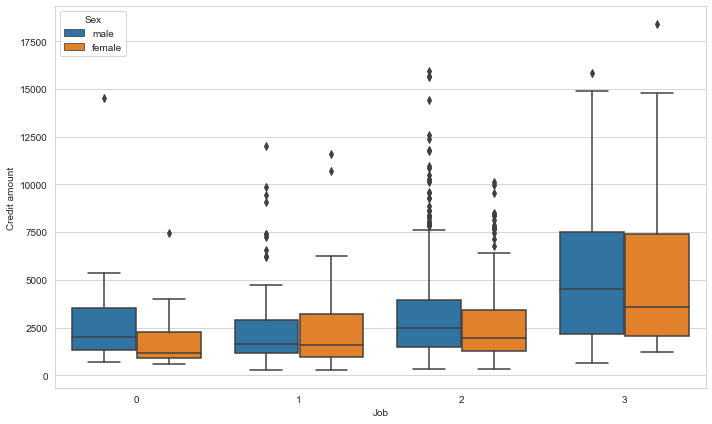

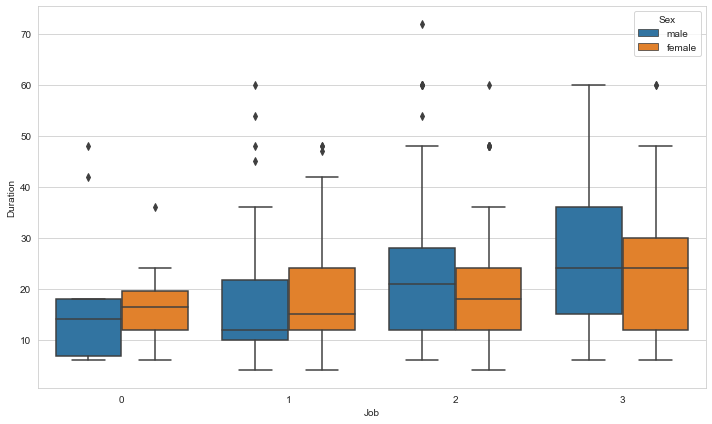

In [21]:
# y = Valor en crédito otorgado
# x = Trabajo 

boxes(df, "Job","Credit amount","Sex",0)

# y = Duración del crédito otorgado
# x = Trabajo

boxes(df, "Job","Duration","Sex",0)

En términos de categoría de trabajo, una vez más, no hay diferencia entre hombres y mujeres, pero se puede ver que la categoría de trabajo 3 (trabajador altamente calificado) tiende a requerir mayores montos de crédito durante más tiempo, mientras que la categoría 0 (desempleado) todo lo contrario.

Graficando en 3D la dispersión entre:
* Cantidad de crédito otorgado (eje x)
* Duración del crédito otorgado (eje y)
* Edad de la persona que recibe el crédito (eje z)

Text(0.5, 0, 'Edad')

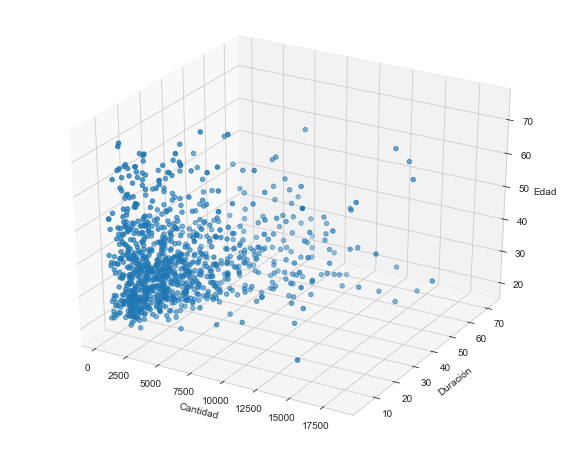

In [22]:
from mpl_toolkits.mplot3d import Axes3D 

fig = plt.figure(figsize=(10,8))
ax = fig.add_subplot(111, projection='3d')
ax.scatter(df["Credit amount"], df["Duration"], df["Age"])
ax.set_xlabel("Cantidad")
ax.set_ylabel("Duración")
ax.set_zlabel("Edad")

## Aplicando K-means

### Pre-procesamiento 

Se debe preparar los datos para poder aplicar el método de clustering, para eso es necesario crear un dataframe que contenga solo variables numéricas, que son las que se graficaron en el gráfico 3D.

In [23]:
#Seleccionando las columnas para aplicar Kmeans

columnas_selec = ["Age","Credit amount", "Duration"]
cluster_data = df.loc[:,columnas_selec]

In [24]:
cluster_data

,Age,Credit amount,Duration
0,67,1169,6
1,22,5951,48
2,49,2096,12
3,45,7882,42
4,53,4870,24
...,...,...,...
995,31,1736,12
996,40,3857,30
997,38,804,12
998,23,1845,45


Visualizando las distribuciones de las 3 variables:

In [25]:
# Creando la función:

def dist_graph(df,x1,x2,x3):
    """
    Función que recibe un dataframe y devuelve tres gráficos de las distribuciones de columnas de ese dataframe.
    """
    fig, (ax1, ax2, ax3) = plt.subplots(3,1, figsize=(8,8))
    sns.distplot(df[x1], ax=ax1, color="#3498db")
    sns.distplot(df[x2], ax=ax2, color="#2ecc71")
    sns.distplot(df[x3], ax=ax3, color="#9b59b6")
    plt.tight_layout()

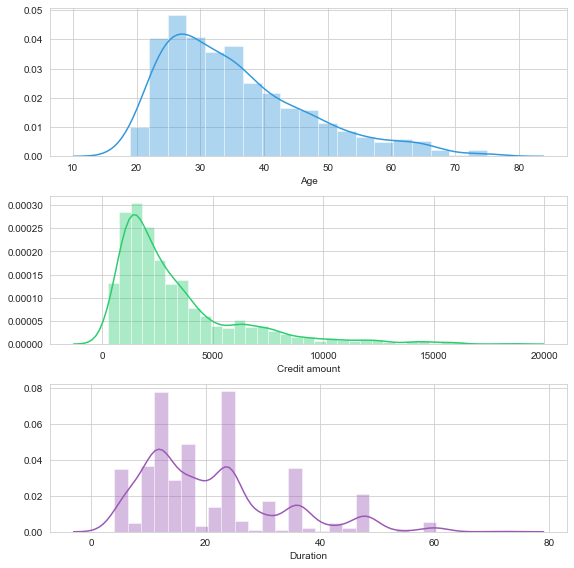

In [26]:
dist_graph(df, "Age", "Credit amount", "Duration")

Puede verse que las distribuciones están sesgadas a la derecha. Para obtener mejores resultados se debe eliminar la asimetría mediante transformación logarítmica.

Más información respecto a información sesgada hacia un lado (media, moda y mediana distintas):

https://en.wikipedia.org/wiki/Skewness
https://blog.prepscholar.com/skewed-right

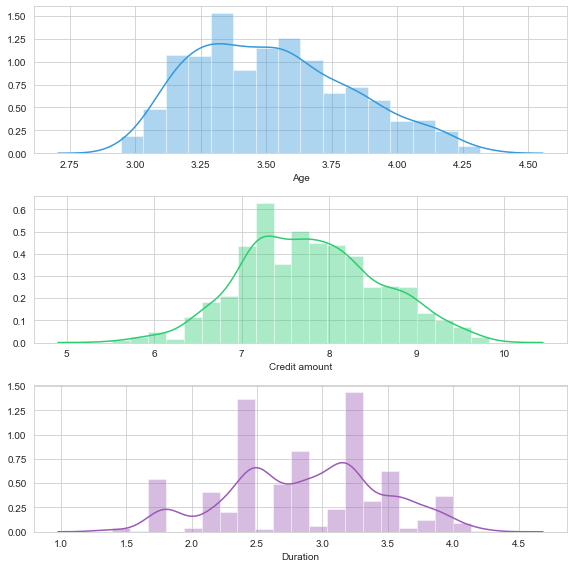

In [27]:
cluster_data_log = np.log(cluster_data)
dist_graph(cluster_data_log, "Age", "Credit amount", "Duration")

Se ha eliminado la asimetría.

El siguiente paso será centrar y escalar las variables, lo que requiere el algoritmo de KMeans. 
Para eso se usará StandardScaler de la librería sklearn.

In [28]:
scaler = StandardScaler() # para escalar las variables
cluster_scaled = scaler.fit_transform(cluster_data_log) #nuevo dataframe a utilizar

In [29]:
cluster_scaled

array([[ 2.27100592, -0.933901  , -1.86486906],
       [-1.44615223,  1.16304581,  1.7083687 ],
       [ 1.22669602, -0.1815588 , -0.67378981],
       ...,
       [ 0.37810951, -1.4161991 , -0.67378981],
       [-1.29778048, -0.34591111,  1.59746802],
       [-0.76258638,  0.82450846,  1.59746802]])

A continuación se verificará cómo cambia la inercia para varios grupos.

El algoritmo de K-medias tiene como objetivo elegir centroides que minimicen la inercia, o el criterio de suma de cuadrados dentro del clúster.

Más información sobre el significado de inercia ("Inertia"): https://scikit-learn.org/stable/modules/clustering.html

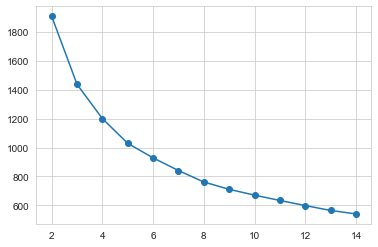

In [30]:
clusters_rango = [2,3,4,5,6,7,8,9,10,11,12,13,14]
inertias = []

for x in clusters_rango:
    kmeans = KMeans(n_clusters=x, random_state=0).fit(cluster_scaled)
    inertias.append(kmeans.inertia_)
plt.figure()
plt.plot(clusters_rango,inertias, marker='o')

El gráfico muestra que la inercia disminuye al aumentar el número de clusters.

Este método permite la evaluación de las separaciones de clusters y el ajuste de cada observación en su propio cluster. Cuanto mayor sea la puntuación, mejor. 

Se deberá realizar éste análisis a varias semillas (seeds).

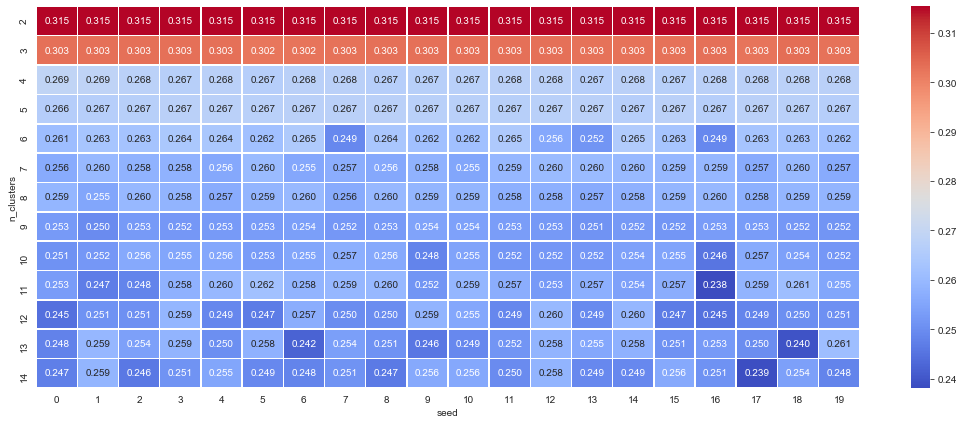

In [31]:
from sklearn.metrics import silhouette_samples, silhouette_score

clusters_rango = range(2,15)
random_rango = range(0,20)
resultados =[]

for c in clusters_rango:
    for r in random_rango:
        clusterer = KMeans(n_clusters=c, random_state=r)
        cluster_labels = clusterer.fit_predict(cluster_scaled)
        silhouette_avg = silhouette_score(cluster_scaled, cluster_labels)
        #print("For n_clusters =", c," and seed =", r,  "\nThe average silhouette_score is :", silhouette_avg)
        resultados.append([c,r,silhouette_avg])

df_resultado = pd.DataFrame(resultados, columns=["n_clusters","seed","silhouette_score"])
pivot_km = pd.pivot_table(df_resultado, index="n_clusters", columns="seed",values="silhouette_score")

plt.figure(figsize=(15,6))
sns.heatmap(pivot_km, annot=True, linewidths=.5, fmt='.3f', cmap="coolwarm")
plt.tight_layout()

El heatmap muestra puntuaciones de silueta para varias combinaciones de estado aleatorio (random state) y número de clusters. Las puntuaciones más altas son para 2 y 3 clusters y son relativamente insensibles a las semillas (seeds).

Se procederá utilizando 3 clusters.

In [32]:
# Aplicando Kmeans con 3 clusters

kmeans_sel = KMeans(n_clusters=3, random_state=1).fit(cluster_scaled)
labels = pd.DataFrame(kmeans_sel.labels_) #etiquetas

clustered_data = cluster_data.assign(Cluster=labels) 

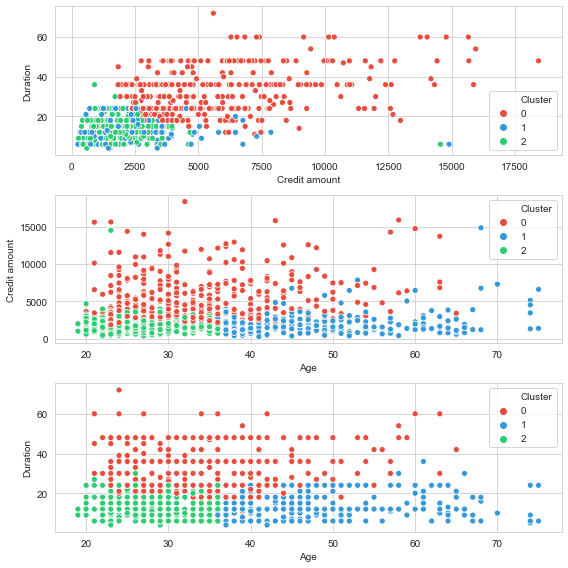

In [33]:
# Visualizando los 3 clusters encontrados:

dispersion(clustered_data, 'Cluster', pal=sns.color_palette(["#e74c3c", "#3498db", "#2ecc71"], 3))

En los 2 ultimos gráficos es bastante clara la separacion entre los grupos encontrados, mientras que en la primera no es tan notable, sobretodo entre los clusters 1 y 2.

In [34]:
grupos_kmeans = clustered_data.groupby(['Cluster']).mean().round(1)
grupos_kmeans

,Age,Credit amount,Duration
Cluster,,,
0,34.0,5665.4,32.2
1,48.7,1979.7,13.9
2,27.8,1732.2,14.2


Los 3 grupos o segmentos encontrados se pueden describir de la siguiente manera:
* Primer grupo (cluster 0): Monto promedio de crédito alto, larga duración, clientes de edad media.
* Segundo grupo (cluster 1): Monto promedio de crédito bajo, corta duración, clientes de edad mayor.
* Tercer grupo (cluster 2): Monto promedio de crédito bajo, corta duración, clientes jóvenes.

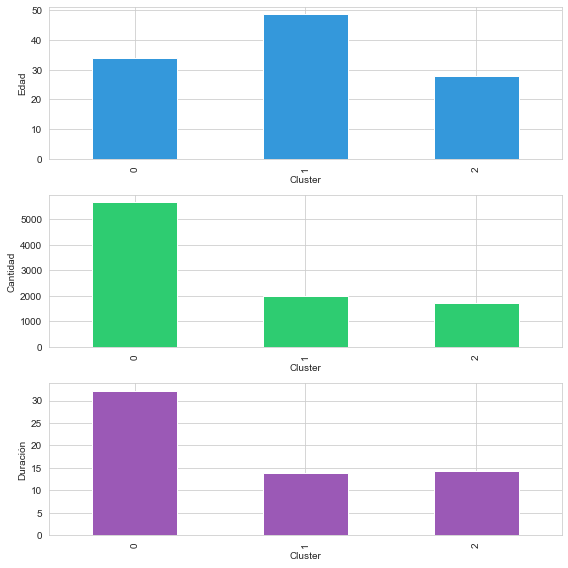

In [35]:
fig, (ax1, ax2, ax3) = plt.subplots(3,1, figsize=(8,8)) # para crear 3 gráficos, uno arriba de otro
ax1 = grupos_kmeans["Age"].plot(kind="bar", ax=ax1, color="#3498db")
ax2 = grupos_kmeans["Credit amount"].plot(kind="bar", ax=ax2, color="#2ecc71")
ax3 = grupos_kmeans["Duration"].plot(kind="bar", ax=ax3, color="#9b59b6")
ax1.set_ylabel('Edad')
ax2.set_ylabel('Cantidad')
ax3.set_ylabel('Duración')
plt.tight_layout()

## Aplicando el algoritmo de Affinity Propagation

La propagación de afinidad (AP) es un algoritmo de agrupamiento basado en el concepto de "paso de mensajes" entre puntos de datos. A diferencia de los algoritmos de agrupación tales como k -means, propagación de afinidad no requiere el número de grupos que se determinada o estimada antes de ejecutar el algoritmo.

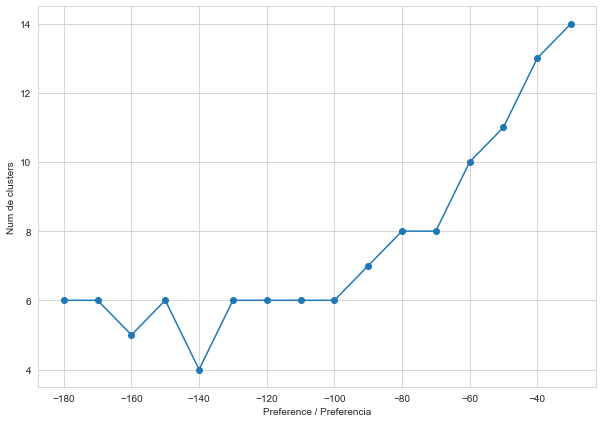

In [40]:
preferencias = np.arange(-30,-190,-10)
clusters = []

for p in preferencias:
    af = AffinityPropagation(preference=p, damping=0.6, max_iter=400, verbose=False).fit(cluster_scaled)
    labels_af = pd.DataFrame(af.labels_)
    clusters.append(len(af.cluster_centers_indices_))

plt.figure(figsize=(10,7))
plt.xlabel("Preference / Preferencia")
plt.ylabel("Num de clusters")
plt.plot(preferencias,clusters, marker='o')

Junto con el valor decreciente del parámetro de preferencia, el número de grupos también desciende y los niveles para valores de preferencia muy pequeños. Se utilizará 4 grupos.

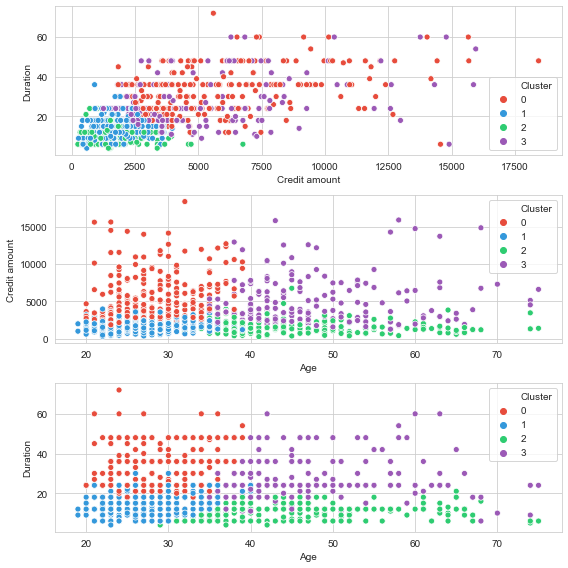

In [44]:
af = AffinityPropagation(preference=-140, damping=0.6, verbose=False).fit(cluster_scaled)
labels_af = pd.DataFrame(af.labels_)
n_clusters_ = len(af.cluster_centers_indices_)

clustered_data_af = cluster_data.assign(Cluster=labels_af)
dispersion(clustered_data_af,'Cluster', pal=sns.color_palette(["#e74c3c", "#3498db", "#2ecc71", "#9b59b6"], 4))

In [45]:
grupo_af = clustered_data_af.groupby(['Cluster']).mean().round(1)
grupo_af

,Age,Credit amount,Duration
Cluster,,,
0,28.7,5593.7,32.2
1,27.9,1654.3,15.1
2,46.0,1551.7,10.7
3,47.5,4977.9,27.6


Los grupos encontrados con este algoritmo son:

* Cluster 0: Monto promedio de crédito alto, larga duración, clientes jóvenes.
* Cluster 1: Monto promedio de crédito bajo, corta duración, clientes jóvenes.
* Cluster 2: Monto promedio de crédito bajo, corta duración, clientes de edad mayor.
* Cluster 3: Monto promedio de crédito alto, larga duración, clientes de edad mayor.